In [1]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import albumentations as A

from athena import Experiments, ClassificationSolver, datasets
from athena.visualizations import plot_experiments, plot_misclassified
from athena.models import ResNet18
from athena.utils.transforms import ToNumpy, ToTensor

## Config

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 128 if torch.cuda.is_available() else 64
epochs = 150

In [3]:
def loss_fn(y_pred, y_true):
    y_pred = F.log_softmax(y_pred, dim=-1)
    return F.nll_loss(y_pred, y_true)

## Defining experiments

In [4]:
exps = (
    Experiments("ResNet-18 - 150 epochs, StepLR with step size 50")
    .log_directory("./logs")
    .add("ResNet with random crop and random horizontal flip")
        .model(ResNet18())
        .solver(ClassificationSolver)
            .optimizer(optim.SGD, lr=0.1, momentum=0.9, weight_decay=5e-4)
            .scheduler(StepLR, step_size=50, gamma=0.1)
            .epochs(epochs)
            .train_loader(
                datasets.cifar10()
                .batch_size(batch_size)
                .train()
                .transform(A.Compose([
                    A.Lambda(ToNumpy),
                    A.RandomCrop(32, 32),
                    A.HorizontalFlip(),
                    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010), max_pixel_value=1.0),
                    A.Lambda(ToTensor)
                ]))
                .build()
            )
            .test_loader(
                datasets.cifar10()
                .batch_size(batch_size)
                .test()
                .transform(A.Compose([
                    A.Lambda(ToNumpy),
                    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010), max_pixel_value=1.0),
                    A.Lambda(ToTensor)
                ]))
                .build()
            )
            .loss_fn(loss_fn)
            .device(device)
            .build()
        .build()
    .add("ResNet with cut out")
        .model(ResNet18())
        .solver(ClassificationSolver)
            .optimizer(optim.SGD, lr=0.1, momentum=0.9, weight_decay=5e-4)
            .scheduler(StepLR, step_size=50, gamma=0.1)
            .epochs(epochs)
            .train_loader(
                datasets.cifar10()
                .batch_size(batch_size)
                .train()
                .transform(A.Compose([
                    A.Lambda(ToNumpy),
                    A.Cutout(num_holes=1, max_h_size=16, max_w_size=16),
                    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010), max_pixel_value=1.0),
                    A.Lambda(ToTensor)
                ]))
                .build()
            )
            .test_loader(
                datasets.cifar10()
                .batch_size(batch_size)
                .test()
                .transform(A.Compose([
                    A.Lambda(ToNumpy),
                    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010), max_pixel_value=1.0),
                    A.Lambda(ToTensor)
                ]))
                .build()
            )
            .loss_fn(loss_fn)
            .device(device)
            .build()
        .build()
    .done()
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
exps.run()

=> Running experiment: ResNet with random crop and random horizontal flip
Epoch: 1 / 150
391/391 [==============================] - 68s 173ms/step - train loss: 2.0113 - train accuracy: 30.9920
Test set: Average loss: 2.1253, Accuracy: 3388/10000 (33.88%)

Epoch: 2 / 150
391/391 [==============================] - 68s 174ms/step - train loss: 1.4411 - train accuracy: 47.2220
Test set: Average loss: 1.5710, Accuracy: 4582/10000 (45.82%)

Epoch: 3 / 150
391/391 [==============================] - 68s 174ms/step - train loss: 1.1937 - train accuracy: 56.6120
Test set: Average loss: 1.2525, Accuracy: 5526/10000 (55.26%)

Epoch: 4 / 150
391/391 [==============================] - 68s 175ms/step - train loss: 0.9724 - train accuracy: 65.4620
Test set: Average loss: 1.9509, Accuracy: 4037/10000 (40.37%)

Epoch: 5 / 150
391/391 [==============================] - 68s 174ms/step - train loss: 0.8191 - train accuracy: 70.9380
Test set: Average loss: 1.0523, Accuracy: 6407/10000 (64.07%)

Epoch: 6 / 

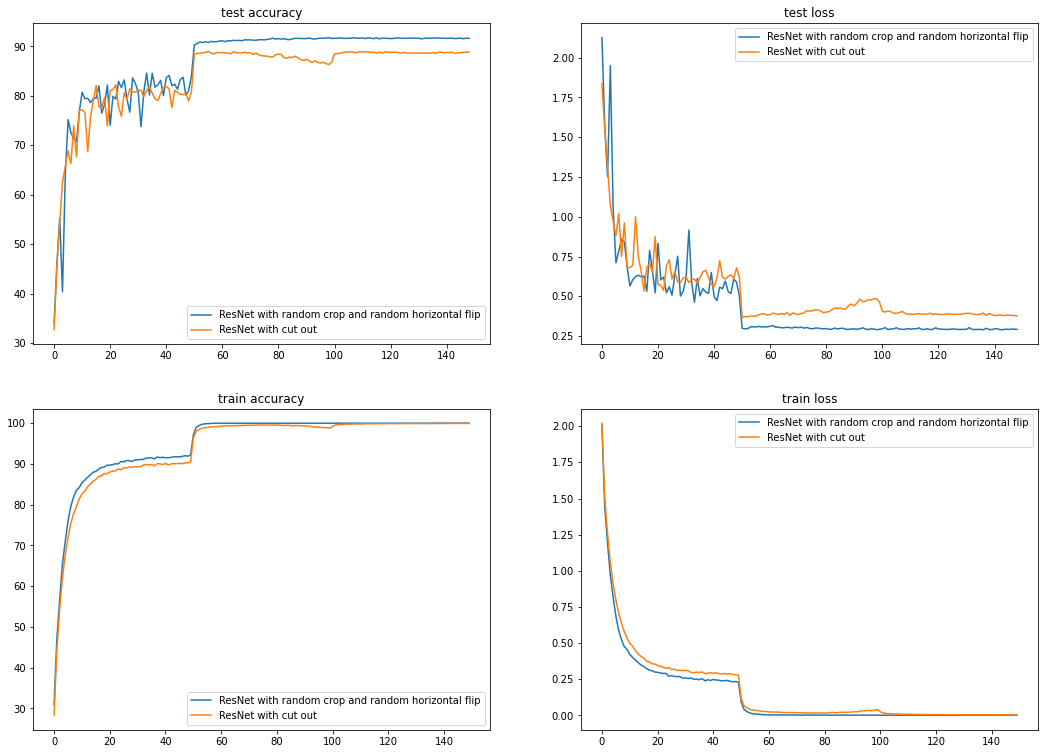

In [6]:
plot_experiments(exps)

## Testing out gradcam with vgg16

In [7]:
from torchvision.models import vgg16
from torchvision import transforms
from PIL import Image
import albumentations as A

from athena.utils.transforms import ToNumpy, ToTensor
from athena.visualizations import apply_gradcam

In [8]:
model = vgg16(pretrained=True)
target_layer = model.features[29]
device = "cuda"

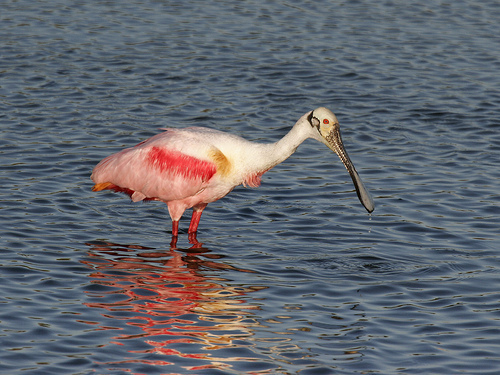

In [9]:
image = Image.open("images/water-bird.jpg")
image

In [10]:
transform = A.Compose([
    A.Lambda(ToNumpy),
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1),
    A.Lambda(ToTensor)
])

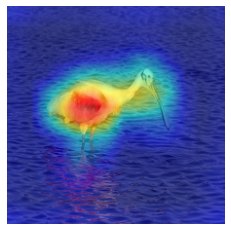

In [11]:
apply_gradcam(
    model,
    target_layer,
    transforms.ToTensor()(image.resize((224, 224))),
    transform=lambda img: transform(image=img)["image"],
    device=device,
    use_gradcampp=True,
)